In [ ]:
import glob, sys, os
import torch
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import pandas as pd
import random
from model.Build_model import build_vlm_model, Main_model
import torch.nn as nn
from torch.utils.data import DataLoader, DistributedSampler
from utils.caption_datasets import COCOCaptionDataset
from utils.lr_sched_cls import LinearWarmupCosineLRScheduler
from tqdm import tqdm

/tmp/ipykernel_69872/3406762564.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
model_config = {'amp':True, 'use_distributed':False,'accum_grad_iters':1, 
                'chat_template': True, 'end_sym': '\n', 'prompt_template': "[INST] {} [/INST]",
                'max_txt_len': 1024, 'max_context_len': 3500,
                'ouput_dir': './exper01_llama2',
                'stage_ckpt': '/ssd3/chih/LLM/MiniGPT-4-ckpt/checkpoint_stage3.pth', 
                'vis_root_train': './dataset/minigpt_casing_train/coco/image/train',
                'ann_paths_train': ['./dataset/minigpt_casing_train/coco_caption/defe_ready_anno.json'],
                'vis_root_valid': './dataset/minigpt_casing_test/coco/image/test',
                'ann_paths_valid': ['./dataset/minigpt_casing_test/coco_caption/defe_ready_anno.json']}

llm_config = {'llama_model':'/ssd3/chih/LLM/Llama-2-7b-chat-hf', 'low_resource':False, 'low_res_device':0, 
              'lora_r':64, 'lora_target_modules':["q_proj", "v_proj"], 'lora_alpha':16,'lora_dropout':0.05
              }
# llm_config = {'llama_model':'/ssd3/chih/LLM/Meta-Llama-3-8B-Instruct', 'low_resource':False, 'low_res_device':0, 
#               'lora_r':64, 'lora_target_modules':["q_proj", "v_proj"], 'lora_alpha':16,'lora_dropout':0.05
#               }
# '/ssd3/chih/LLM/Meta-Llama-3-8B-Instruct'


vit_config = {'model_name':'eva_clip_g', 'image_size': 448,  'drop_path_rate': 0, 'use_grad_checkpoint': True, 'vit_precision': 'fp16', 'freeze_vit': True, }

lr_config = {'init_lr': 1e-5, 'beta2':0.999,'min_lr': 1e-6, 'decay_rate': None, 'weight_decay':0.05,
                'warmup_start_lr': 1e-6, 'warmup_steps': 1000, 'iters_per_epoch': 100}

In [ ]:
class Main__:
    def __init__(self, model_config: dict):
        super().__init__()
        self.model_config = model_config
        self.save_path = os.path.join(os.path.join(self.model_config['ouput_dir']))
        os.makedirs(self.save_path, exist_ok=True)
        self.end_sym = self.model_config['end_sym']
        self.max_context_len = self.model_config['max_context_len']
        self.max_txt_len = self.model_config['max_txt_len']
        self.chat_template = self.model_config['chat_template']
        self.prompt_template = self.model_config['prompt_template']
        self.distributed_ = self.model_config['use_distributed']
        self.scaler = None
        self.curr_device = None #從sample定位

    def distributed_DDP(self,device_ids=[]):
        from torch.nn.parallel import DistributedDataParallel as DDP
        self.model = DDP(self.model, device_ids=device_ids, find_unused_parameters=True)
        
    def get_context_emb(self, prompt, img_list):
        device = img_list[0].device
        prompt_segs = prompt.split('<ImageHere>')
        assert len(prompt_segs) == len(img_list) + 1, "Unmatched numbers of image placeholders and images."
        seg_tokens = [
            self.model.llama_tokenizer(
                seg, return_tensors="pt", add_special_tokens=i==0).to(device).input_ids # only add bos to the first seg
            for i, seg in enumerate(prompt_segs)
        ]
        seg_embs = [self.embed_tokens(seg_t) for seg_t in seg_tokens]

        mixed_embs = [emb for pair in zip(seg_embs[:-1], img_list) for emb in pair] + [seg_embs[-1]]
        # print("mixed_embs-0", len(mixed_embs))
        # print(f"前後文字與中間影像embedding shape: 前){mixed_embs[0].shape} 中) {mixed_embs[1].shape} 後){mixed_embs[2].shape}")
        mixed_embs = torch.cat(mixed_embs, dim=1)
        # print("前後文字與影像合併後shape", mixed_embs.shape)
        return mixed_embs

    def chat_module(self, samples = None): #不太穩定，僅供測試，直接從minigpt搬過來，尚未整理
        atts_img, img_embeds = self.encode_img(samples['image'])
        image_lists = [[image_emb[None]] for image_emb in img_embeds]
        batch_embs = [self.get_context_emb(text, img_list) for text, img_list in zip(samples['instruction_input'], image_lists)]
        batch_size = len(batch_embs)
        max_len = max([emb.shape[1] for emb in batch_embs])
        emb_dim = batch_embs[0].shape[2]
        dtype = batch_embs[0].dtype
        device = batch_embs[0].device
        embs = torch.zeros([batch_size, max_len, emb_dim], dtype=dtype, device=device)
        attn_mask = torch.zeros([batch_size, max_len], dtype=torch.int, device=device)
        for i, emb in enumerate(batch_embs):
            emb_len = emb.shape[1]
            embs[i, -emb_len:] = emb[0]
            attn_mask[i, -emb_len:] = 1
        with torch.cuda.amp.autocast(dtype=torch.float16):
            outputs = self.model.llama_model.generate(
                inputs_embeds=embs,
                attention_mask=attn_mask,
                max_new_tokens=1024,
                num_beams=1,
                length_penalty=1,
                temperature=1,
                do_sample=False,
                min_length=1,
                top_p=0.9,
                repetition_penalty=1,
            )
        answers = []
        for output_token in outputs:
            if output_token[0] == 0:
                output_token = output_token[1:]
            output_texts = self.model.llama_tokenizer.decode(output_token, skip_special_tokens=True)
        answers.append(output_texts)
        return answers
    
    def concat_emb_input_output(self, input_embs, input_atts, output_embs, output_atts):
        """
        Concatenate the batched input embedding and batched output embedding together.
        Both the input and the output embedding should be right padded.
        """
        input_lens = []
        cat_embs = []
        cat_atts = []
        for i in range(input_embs.size(0)):
            input_len = input_atts[i].sum()
            input_lens.append(input_len)
            cat_embs.append(
                torch.cat([
                    input_embs[i][:input_len],
                    output_embs[i],
                    input_embs[i][input_len:]
                ])
            )
            cat_atts.append(
                torch.cat([
                    input_atts[i][:input_len],
                    output_atts[i],
                    input_atts[i][input_len:]
                ])
            )
        cat_embs = torch.stack(cat_embs)
        cat_atts = torch.stack(cat_atts)
        return cat_embs, cat_atts, input_lens
    
    def embed_tokens(self, token_ids):
        # print("token_ids: ", token_ids)
        if hasattr(self.model.llama_model.base_model, 'model'): ## lora wrapped model
            embeds = self.model.llama_model.base_model.model.model.embed_tokens(token_ids)
        else:
            embeds = self.model.llama_model.base_model.embed_tokens(token_ids)
        return embeds
    
    def prompt_wrap(self, img_embeds, atts_img, prompts, lengths=None, tokenizer = None):    
        # print(img_embeds.shape, atts_img.shape)
        emb_lists = []
        if isinstance(prompts, str):
            prompts = [prompts] * len(img_embeds)
        
        # 每一個batch一個一個處理
        for idx, (each_img_embed, each_prompt) in enumerate(zip(img_embeds, prompts)):
            pn = each_img_embed.shape[-2]
            p_segs = each_prompt.split('<ImageHere>')
            # print(p_segs)
            interleave_emb = []
            # 前半段句子
            for idx, seg in enumerate(p_segs[:-1]): #該loop是為了應用於影片，單張圖像也可使用
                p_tokens = tokenizer(seg, return_tensors="pt", add_special_tokens=False).to(img_embeds.device)
                p_embed = self.embed_tokens(p_tokens.input_ids)
                # interleave_emb.append(torch.cat([p_embed, each_img_embed[None][:, idx * pn:(idx + 1) * pn]], dim=1))
                interleave_emb.append(torch.cat([p_embed, each_img_embed.unsqueeze(0)], dim=1))
            # 前半段句子'<Img>'+圖像'{image embed}'
            wrapped_emb = torch.cat(interleave_emb, dim=1)
            p_tokens = tokenizer(p_segs[-1], return_tensors="pt", add_special_tokens=False).to(img_embeds.device)
            p_embed = self.embed_tokens(p_tokens.input_ids)
            wrapped_emb = torch.cat([wrapped_emb, p_embed], dim=1)
            emb_lists.append(wrapped_emb)
        emb_lens = [emb.shape[1] for emb in emb_lists]
        pad_emb = self.embed_tokens(torch.tensor(tokenizer.pad_token_id, device=img_embeds.device))
        max_length = max(emb_lens) if max(emb_lens) < self.max_context_len else self.max_context_len
        wrapped_embs = pad_emb.expand(len(emb_lens), max_length, -1).clone()
        wrapped_atts = torch.zeros([len(emb_lens), max_length], dtype=torch.int, device=img_embeds.device)
        
        # 每一個batch一個一個處理
        for i, emb in enumerate(emb_lists):
            length = emb_lens[i] if emb_lens[i] < self.max_context_len else self.max_context_len
            wrapped_embs[i, :length] = emb[:, :length]
            wrapped_atts[i, :length] = 1
        return wrapped_embs, wrapped_atts
    
    def VLM_build(self, llm_config:dict, vit_config:dict):
        self.llm_config = llm_config
        self.vit_config = vit_config
        self.model = Main_model(llm_config=llm_config, vit_config=vit_config)
        if torch.cuda.is_available():
            self.model = self.model.cuda()
            
    def init_optimizer(self, lr_config:dict):
        num_parameters = 0
        p_wd, p_non_wd = [], []
        for n, p in self.model.named_parameters():
            if not p.requires_grad:
                continue
            if p.ndim <2 or 'bias' in n or 'ln' in n or 'bn' in n:
                p_non_wd.append(p)
            else:
                p_wd.append(p)
            num_parameters+=p.data.nelement()
            optim_params = [
                {
                    "params": p_wd,
                    "weight_decay": lr_config['weight_decay'],
                },
                {"params": p_non_wd, "weight_decay": 0},
            ]
            beta2 = lr_config['beta2']
            self.optimizer = torch.optim.AdamW(
                optim_params,
                lr=float(lr_config['init_lr']),
                weight_decay=lr_config['weight_decay'],
                betas=(0.9, beta2),
            )
        return self.optimizer
    
    def lr_scheduler_cls(self, lr_config: dict):
        self._lr_sched = LinearWarmupCosineLRScheduler(
            optimizer=self.optimizer,
            max_epoch=int(self.max_epoch),
            iters_per_epoch=int(lr_config['iters_per_epoch']),
            min_lr=lr_config['min_lr'],
            init_lr=lr_config['init_lr'],
            decay_rate=lr_config['decay_rate'],
            warmup_start_lr=lr_config['warmup_start_lr'],
            warmup_steps=lr_config['warmup_steps'],
        )
        return self._lr_sched
    
    def load_checkpoint(self, ckpt_url: str):  
        weight = torch.load(ckpt_url, map_location="cpu")['model']
        self.model.load_state_dict(weight, strict=False)
        
    def _save_checkpoint(self, cur_epoch, is_best=False):
        if self.distributed_:
            model_no_ddp = self.model.module
        else:
            model_no_ddp = self.model
        param_grad_dic = {
            k: v.requires_grad for (k, v) in model_no_ddp.named_parameters()
        }
        state_dict = model_no_ddp.state_dict() 
        for k in list(state_dict.keys()):#只保留有做gradient的layer做儲存(e.g: lora、prompt layer)
            if k in param_grad_dic.keys() and not param_grad_dic[k]:
                del state_dict[k]
        save_obj = {
            "model": state_dict,
            "optimizer": self.optimizer.state_dict(),
            "config":{
                'model_config':self.model_config,
                'llm_config':self.llm_config,
                'vit_config':self.vit_config
                },
            "scaler": self.scaler.state_dict() if self.scaler else None,
            "epoch": cur_epoch,
        }
        save_to = os.path.join(
            self.save_path,
            "checkpoint_{}.pth".format("best" if is_best else cur_epoch),
        )
        self.best_weight = save_obj
        
        torch.save(save_obj, save_to)
    def encode_img(self, image):
        with torch.cuda.amp.autocast(dtype=torch.float16):
            image_embeds = self.model.ln_vision(self.model.visual_encoder(image))
            image_embeds = image_embeds[:, 1:, :]
            bs, pn, hs = image_embeds.shape
            image_embeds = image_embeds.view(bs, int(pn / 4), int(hs * 4))
            img_embeds = self.model.llama_proj(image_embeds.cuda().to(torch.float32))
            img_atts = torch.ones(img_embeds.size()[:-1], dtype=torch.long).to(image.device)
            return img_atts, img_embeds
            
    def train_step(self, model = None, samples = None, p_type = 'train'):
        if torch.cuda.is_available():
            image = samples["image"].cuda()
        else:
            image = samples["image"]
        self.curr_device = image.device

        img_atts, img_embeds = self.encode_img(image)
    
        # question process
        instruction = samples["instruction_input"]
        if self.chat_template: #添加[INSt]{}[/INST]
                instruction = [self.prompt_template.format(instruct) for instruct in instruction]
        cond_embeds, cond_atts = self.prompt_wrap(img_embeds, img_atts, instruction, tokenizer = self.model.llama_tokenizer)

        # answer process
        self.model.llama_tokenizer.padding_side = 'right'
        text = [t + self.end_sym for t in samples["answer"]] # 加上換行結束符號
        regress_tokens = self.model.llama_tokenizer(text,
                                            return_tensors="pt", padding="longest", truncation=True, 
                                            max_length=self.max_txt_len, add_special_tokens=False
                                            ).to(self.curr_device)
        regress_token_ids = regress_tokens.input_ids
        regress_atts = regress_tokens.attention_mask
        part_targets = regress_token_ids.masked_fill(regress_token_ids == self.model.llama_tokenizer.pad_token_id, -100)
        regress_embeds = self.embed_tokens(regress_token_ids)
        
        # concat the embedding to condition and the embedding to regress
        inputs_embeds, attention_mask, input_lens = self.concat_emb_input_output(cond_embeds, cond_atts, regress_embeds, regress_atts)
        bos = torch.ones_like(part_targets[:, :1]) * self.model.llama_tokenizer.bos_token_id
        bos_embeds = self.embed_tokens(bos)
        bos_atts = cond_atts[:, :1]

        # add bos token at the begining
        inputs_embeds = torch.cat([bos_embeds, inputs_embeds], dim=1)
        attention_mask = torch.cat([bos_atts, attention_mask], dim=1)
        
        # ensemble the final targets
        targets = torch.ones([inputs_embeds.shape[0], inputs_embeds.shape[1]],
                            dtype=torch.long).to(self.curr_device).fill_(-100)
        for i, target in enumerate(part_targets):
            targets[i, input_lens[i]+1:input_lens[i]+len(target)+1] = target  # plus 1 for bos
            
        # input data, get loss
        outputs = self.model.llama_model(
                inputs_embeds=inputs_embeds,
                attention_mask=attention_mask,
                return_dict=True,
                labels=targets,
                reduction='mean'
            )
        loss = outputs["loss"]    
        return loss
    
    def valid(self, dataloader = None, cur_epoch=None):
        valid_loss_stack = []
        with torch.no_grad():
            if self.distributed_:
                model_no_ddp = self.model.module
            else:
                model_no_ddp = self.model
            model_no_ddp.eval()
            # for cur_iter in tqdm(range(100)):
            for cur_iter in tqdm(range(dataloader.__len__())):
                samples = next(iter(dataloader))
                with torch.cuda.amp.autocast(enabled=True):
                    loss = self.train_step(model=self.model, samples=samples, p_type='valid')
                    valid_loss_stack.append(loss.item())
            avg_loss = np.average(valid_loss_stack)
            print("*************************************************************")
            print(f"[Epoch: {cur_epoch} End]Validation Average loss = {avg_loss}")
            print("*************************************************************")
            
            if avg_loss<self.best_loss:
                self._save_checkpoint(cur_epoch=cur_epoch, is_best=True)
                self.best_loss = avg_loss
            else:
                self.model.load_state_dict(self.best_weight['model'], strict=False)
                print("*************************************************************")
                print(f"Loading best epoch from: {self.best_weight['epoch']}!!!!!!!!!!!")
                print("*************************************************************")
    def trainer(self, dataloader = None, cur_epoch=None):
        train_loss_stack = []
        # 採用minigpt，依照設定每一個epoch的iteration的長度建立train process
        # 可以方便調整scaler、
        self.model.train()
        # for samples in dataloader:
        for cur_iter in range(self.lr_config['iters_per_epoch']):
            # samples = {'image': torch.tensor, 'answer': str, 'instruction_input':str,
            #            'epoch': int, 'num_iters_per_epoch':int, 'iters':int}
            if cur_iter >= self.lr_config['iters_per_epoch']:
                break
            samples = next(iter(dataloader))
            samples.update(
                {
                    "epoch": cur_epoch,
                    "num_iters_per_epoch": self.lr_config['iters_per_epoch'],
                    "iters": cur_iter,
                }
            )
            with torch.cuda.amp.autocast(enabled=True):
                loss = self.train_step(model=self.model, samples=samples)
            
            if self.model_config['amp']:
                self.scaler.scale(loss).backward()
            else:
                loss.backward()
            # update gradients every accum_grad_iters iterations
            if (cur_iter+1) % self.model_config['accum_grad_iters'] ==0:
                if self.model_config['amp']:
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
                else:
                    self.optimizer.step()
            self.optimizer.zero_grad()
            train_loss_stack.append(loss.item())
            if cur_iter%100==0 and cur_iter!=0:
                print(f"[Epoch: {cur_epoch}][{cur_iter}/{self.lr_config['iters_per_epoch']}]Current Average loss = {np.average(train_loss_stack)}")
            # break
        print(f"[Epoch: {cur_epoch} End]Average loss = {np.average(train_loss_stack)}")
    def main_process(self, max_epoch = 20,lr_config=None):
        self.lr_config = lr_config
        self.best_agg_metric = 0
        self.best_epoch = 0
        self.best_loss = np.inf
        if self.distributed_:
            self.distributed_DDP(device_ids=[0,1])
        self.max_epoch = max_epoch
        if self.model_config['amp']:
            self.scaler = torch.cuda.amp.GradScaler()
        self.optimizer = self.init_optimizer(lr_config = self.lr_config)
        self.lr_scheduler = self.lr_scheduler_cls(lr_config = self.lr_config)
        
        train_data_set = COCOCaptionDataset(vis_root=self.model_config['vis_root_train'], 
                                      ann_paths=self.model_config['ann_paths_train'],
                                      img_size = self.vit_config['image_size'])
        train_dataloader =DataLoader(train_data_set, batch_size=1, num_workers=1, shuffle=True, pin_memory=True)
        
        if self.model_config['vis_root_valid']!=None and self.model_config['ann_paths_valid']!=None:
            valid_data_set = COCOCaptionDataset(vis_root=self.model_config['vis_root_train'], 
                                                ann_paths=self.model_config['ann_paths_train'],
                                                img_size = self.vit_config['image_size'])
            valid_dataloader = DataLoader(valid_data_set, batch_size=1, num_workers=1, shuffle=True, pin_memory=True)
        else:
            valid_dataloader = DataLoader(train_data_set, batch_size=1, num_workers=1, shuffle=False, pin_memory=True)
        
        
        for cur_epoch in range(1, self.max_epoch):
            self.trainer(dataloader=train_dataloader, cur_epoch=cur_epoch)
            self.valid(dataloader=valid_dataloader, cur_epoch=cur_epoch)
            # break


In [ ]:
main_ = Main__(model_config=model_config)
main_.VLM_build(llm_config=llm_config, vit_config=vit_config)

In [ ]:
main_.main_process(max_epoch=3, lr_config=lr_config)

In [ ]:
# # demo測試對話反饋
# train_data_set = COCOCaptionDataset(vis_root=model_config['vis_root_train'], 
#                                 ann_paths=model_config['ann_paths_train'])
# dataloader =DataLoader(train_data_set, batch_size=1, num_workers=1, shuffle=False, pin_memory=True)
# # ckpt_url = '/ssd3/chih/MiniGPT-4_PhisonVer/demo_ckpt/casting_checkpoint_49_137.pth' 
# # main_.load_checkpoint(ckpt_url=ckpt_url)
# samples = next(iter(dataloader))
# samples['image'] = samples['image'].cuda()
# ans = main_.chat_module(samples=samples)
# print(ans)
# ['there are defects in the product in the photo']

In [ ]:
# param_grad_dic = {
#     k: v.requires_grad for (k, v) in main_.model.named_parameters()
# }

In [ ]:
valid_data_set = COCOCaptionDataset(vis_root=model_config['vis_root_valid'], 
                                    ann_paths=model_config['ann_paths_valid'],
                                    img_size = vit_config['image_size'])

for i in valid_data_set:
    break
i['image'].shape

ann paths ['/ssd3/chih/Dataset/minigpt_casing_test/coco_caption/defe_ready_anno.json']
{'caption': 'Defective.', 'image': '/home/deepmentor/acvlab_exper/dataset/minigpt_casing_test/coco/image/test/casting512x512_deffront_0.jpeg', 'image_id': 'casting512x512_deffront_0.jpeg', 'instance_id': '0'}
/ssd3/chih/Dataset/minigpt_casing_test/coco/image/test/casting512x512_okfront_1169.jpeg 



torch.Size([3, 448, 448])

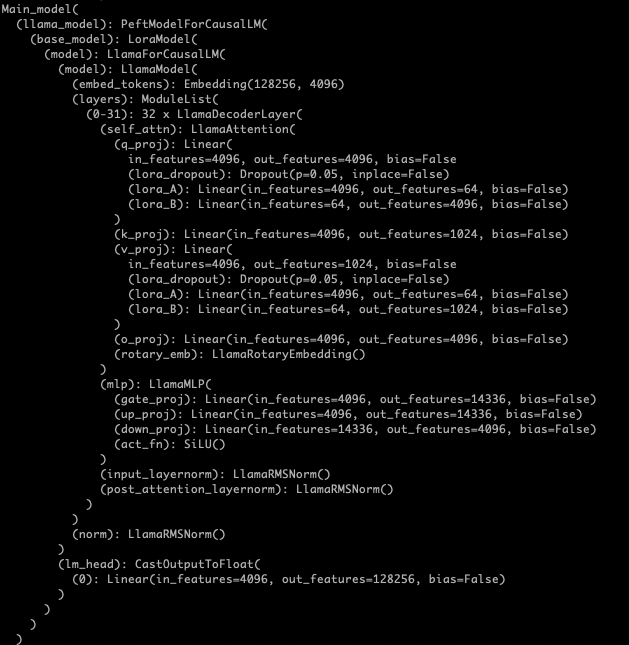